# Bittergourd NPK Assessment | EfficiencyNet B0

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import keras
from keras import layers
from keras.applications import EfficientNetB0
import os

In [21]:
# CONSTANTS
IMAGE_SIZE = 224 #INPUT SIZE FOR EffNetB3
BATCH_SIZE = 24 #BACTH SIZE FOR EffNetB3
CLASSES = 4
EPOCHS = 50

# Declaring the model

In [3]:
model = EfficientNetB0(weights='imagenet')

# Dataset declaration

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "../Bitter_Gourd", #Folder name or directory
    shuffle=True, #shuffles dataset
    image_size = (IMAGE_SIZE, IMAGE_SIZE), #Fixed Image Dimensions
    batch_size = BATCH_SIZE, #Batch Size
)
print(f"Data set length is: {len(dataset)}")

Found 2223 files belonging to 4 classes.
Data set length is: 186


In [5]:
class_names = dataset.class_names
class_names

['Downey mildew', 'Fresh leaf', 'Fusarium wilt', 'Mosaic virus']

# Make sure we can access the Photos

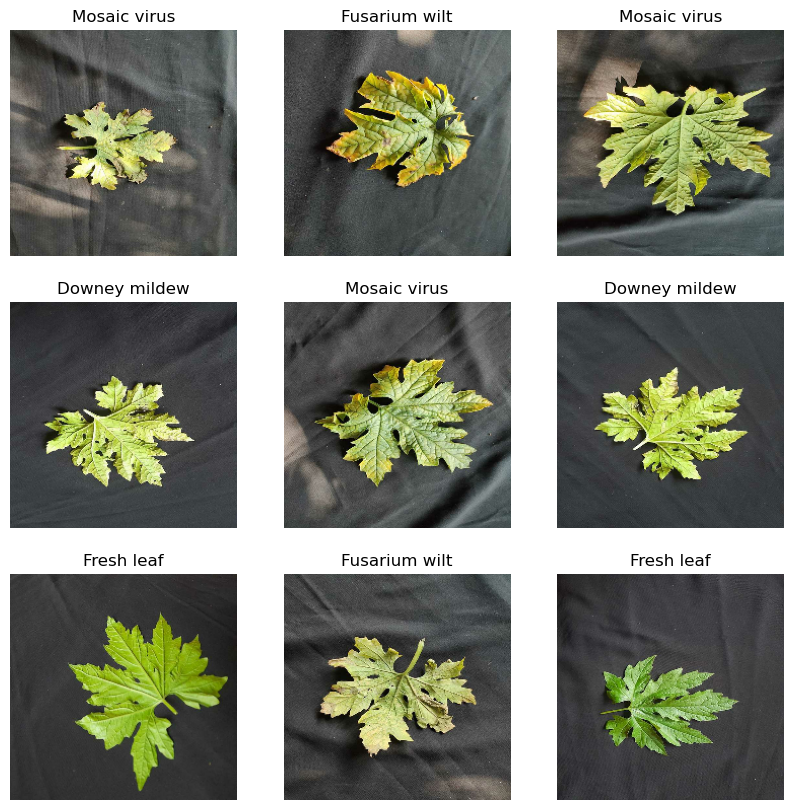

In [6]:
plt.figure(figsize=(10, 10))
for image_batch, label_batch in dataset.take(1):
    batch_size = image_batch.shape[0]  # Get the actual batch size
    num_images = min(batch_size, 9)  # Limit to 9 images
    for i in range(num_images):
        ax = plt.subplot(3, 3, i + 1)  # Create a 3x3 grid for 9 images
        plt.imshow(image_batch[i].numpy().astype("uint8"))  # Convert to uint8 for display
        plt.title(class_names[label_batch[i]])
        plt.axis("off")


# Function to spilt dataset into 80-10-10

In [7]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    
    #get length of dataset
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12) #shuffles dataset before splitting
    
    #computer percentage accordingly from dataset size
    train_size = int(train_split * ds_size) #muliplies train_split parameter to dataset size
    val_size = int(val_split * ds_size) #muliplies val_split parameter to dataset size
    
    train_ds = ds.take(train_size) #stores train_size values
    
    val_ds = ds.skip(train_size).take(val_size) #takes val_size from skipped dataset size
    test_ds = ds.skip(train_size).skip(val_size) 
    
    return train_ds, val_ds, test_ds

In [8]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

#Confirm sizes of each partitions
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

148
18
20


In [9]:
size = (IMAGE_SIZE, IMAGE_SIZE)
ds_train = train_ds.map(lambda image, label: (tf.image.resize(image, size), label))
ds_test = val_ds.map(lambda image, label: (tf.image.resize(image, size), label))

# Data augmentation

In [10]:
img_augmentation_layers = [
    layers.RandomRotation(factor=0.15),
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    layers.RandomFlip(),
    layers.RandomContrast(factor=0.1),
]

def augmentation(images):
    for layer in img_augmentation_layers:
        images = layer(images)
    return images

In [11]:
# One-hot / categorical encoding
def input_preprocess_train(image, label):
    image = augmentation(image)
    label = tf.one_hot(label, CLASSES)
    return image, label


def input_preprocess_test(image, label):
    label = tf.one_hot(label, CLASSES)
    return image, label


ds_train = ds_train.map(input_preprocess_train, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.batch(batch_size=BATCH_SIZE, drop_remainder=True)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

ds_test = ds_test.map(input_preprocess_test, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(batch_size=BATCH_SIZE, drop_remainder=True)


In [12]:
model = EfficientNetB0(
    include_top=True,
    weights=None,
    classes=CLASSES,
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
)
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_2 (Rescaling)        (None, 224, 224, 3)  0           ['input_2[0][0]']                
                                                                                                  
 normalization_1 (Normalization  (None, 224, 224, 3)  7          ['rescaling_2[0][0]']            
 )                                                                                                
                                                                                     

In [22]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/50
148/148 [==============================] - 18s 111ms/step - loss: 0.1843 - accuracy: 0.9242 - val_loss: 0.6400 - val_accuracy: 0.7917
Epoch 2/50
148/148 [==============================] - 18s 112ms/step - loss: 0.1447 - accuracy: 0.9336 - val_loss: 0.0815 - val_accuracy: 0.9583
Epoch 3/50
148/148 [==============================] - 18s 114ms/step - loss: 0.1259 - accuracy: 0.9377 - val_loss: 0.2011 - val_accuracy: 0.9167
Epoch 4/50
148/148 [==============================] - 18s 112ms/step - loss: 0.1284 - accuracy: 0.9349 - val_loss: 0.1451 - val_accuracy: 0.9167
Epoch 5/50
148/148 [==============================] - 18s 111ms/step - loss: 0.1153 - accuracy: 0.9428 - val_loss: 0.0884 - val_accuracy: 0.9491
Epoch 6/50
148/148 [==============================] - 18s 111ms/step - loss: 0.1211 - accuracy: 0.9336 - val_loss: 0.0782 - val_accuracy: 0.9398
Epoch 7/50
148/148 [==============================] - 18s 111ms/step - loss: 0.1600 - accuracy: 0.9285 - val_loss: 0.2927 - val_ac

In [23]:
scores = model.evaluate(test_ds)

20/20 [==============================] - 2s 34ms/step - loss: 0.1440 - accuracy: 0.9375


# Plotting Data

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

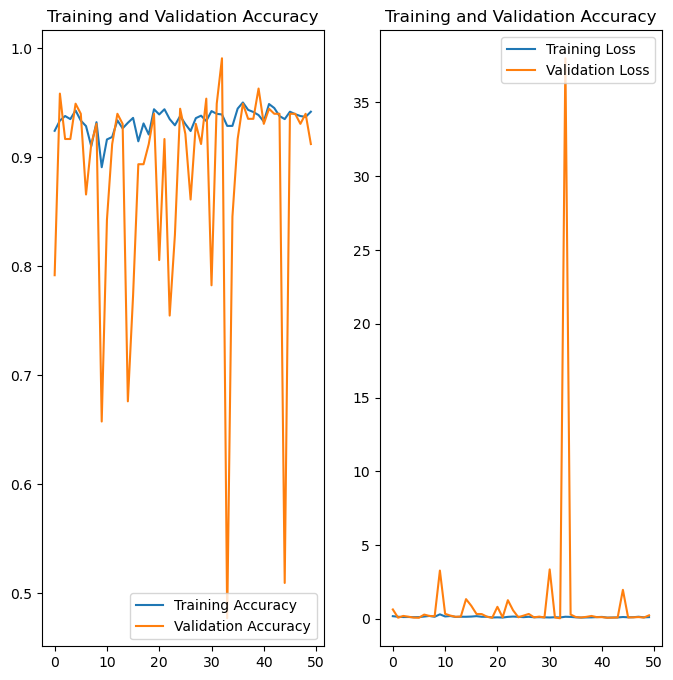

In [25]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Accuracy')
plt.show()

Image to predict
Actual label:  Fusarium wilt
1/1 [==============================] - 0s 42ms/step
Prediction:  Fusarium wilt


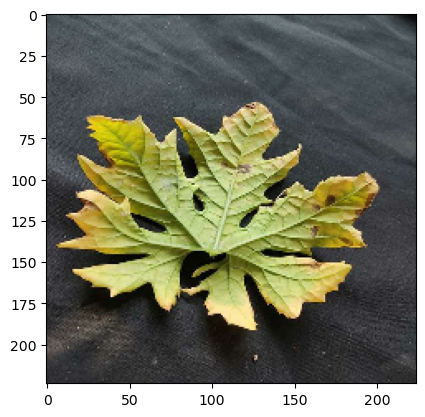

In [26]:
for image_batch, label_batch in test_ds.take(1):
    
    first_image = image_batch[0].numpy().astype('uint8')
    first_label = label_batch[0]
    
    print("Image to predict")
    plt.imshow(first_image)
    print("Actual label: ", class_names[first_label])
    
    batch_prediction = model.predict(image_batch)
    print("Prediction: ", class_names[np.argmax(batch_prediction[0])])


# Prediction

In [27]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) #Create a batch

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 32ms/step


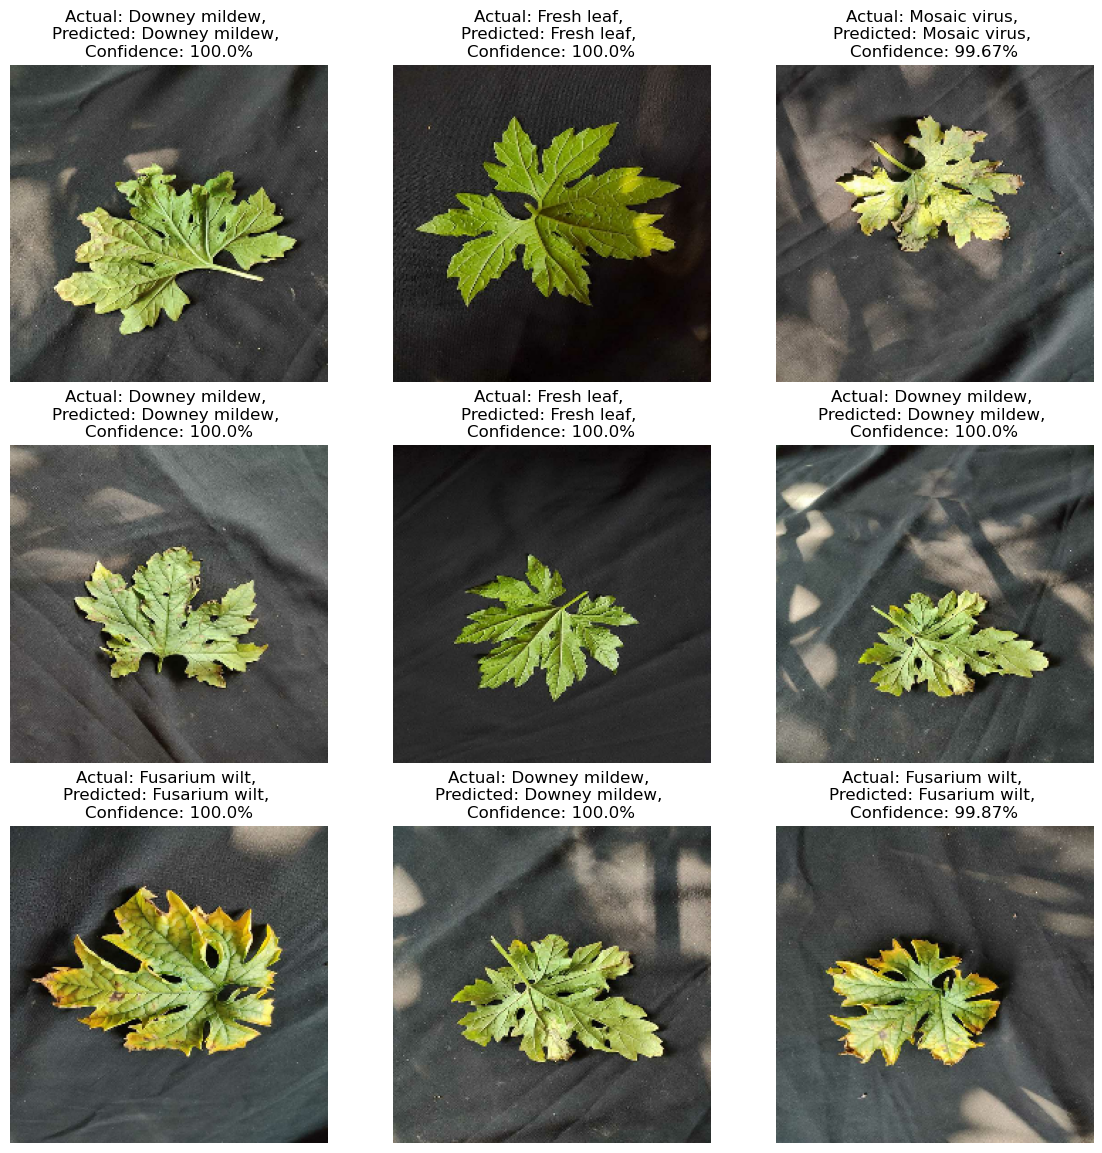

In [28]:
plt.figure(figsize=(14, 14))
for images, labels in test_ds.take(1):
    batch_size = images.shape[0]  # get the actual number of images in the batch
    for i in range(min(9, batch_size)):  # ensure you don't exceed the available number of images
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual: {actual_class}, \nPredicted: {predicted_class}, \nConfidence: {confidence}%")
        plt.axis("off")


# Saving and Exporting

In [36]:
model_version = max([int(i) for i in os.listdir("../models") + [0]]) + 1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/2\assets


INFO:tensorflow:Assets written to: ../models/2\assets
